In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import six
%matplotlib inline


Note: You have to have the file and the correct path

In [15]:
#Read the tsv file
df=pd.read_csv("az20.txt",delimiter = '\t', index_col=False) # You have to have the file and the correct path
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups') 
df=df.loc[df['Substrate'].str.contains('(None)|(M\d+)')==False] # removing any with m residues or no residues (None)
#print df

In [16]:
#Separating columns into individual dataframes to use for later calculation and volcano plot
df1=pd.DataFrame(data=df['Substrate'])
df4=pd.DataFrame(data=df['AZ20_fold_change'])
df5=pd.DataFrame(data=df['AZ20_p-value'])


# Volcano Plot

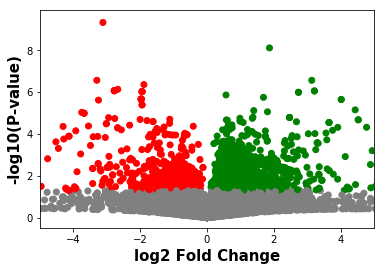

In [17]:
#Extracting significant values and removing zero values from fold change
df4 = df4.replace([np.inf, -np.inf], np.nan)
df4a = df4.dropna(axis=0, how='any')
df4b = df4a[(df4a['AZ20_fold_change'] > 0.0000000)]#removing zero values from fold change
sig = df5[(df5['AZ20_p-value'] < 0.05)] #Extracting significant values 
fcut = np.log2(df4b)


#Creating the Volcano Plot
df['log2'] = (np.log2(df4b))
df.loc[(df['log2'] >= 0) & (df5['AZ20_p-value'] < 0.05), 'color'] = "green"  # upregulated substrates
df.loc[(df['log2'] <= 0) & (df5['AZ20_p-value'] < 0.05), 'color'] = "red"  # downregulated substrates
df['color'].fillna('grey', inplace=True) # substrates which aren't up and down regulated coloured grey
df['logpv'] = -(np.log10(df5['AZ20_p-value'])) # -log10 p value
plt.scatter(df['log2'], df['logpv'], c=df['color']) #Plotting the log2 (fold change) against log 10 (p value)
plt.xlabel('log2 Fold Change', fontsize=15, fontname="sans-serif", fontweight="bold") # labelled x axis
plt.ylabel('-log10(P-value)', fontsize=15, fontname="sans-serif", fontweight="bold") # labelled y axis
plt.xlim(-5,5)  # set the x axis limit (-5,5)
plt.xticks(fontsize=10, fontname="sans-serif")
plt.yticks(fontsize=10, fontname="sans-serif")
plt.show()

# Top 10 Up regulated and Top 10 Downregulated

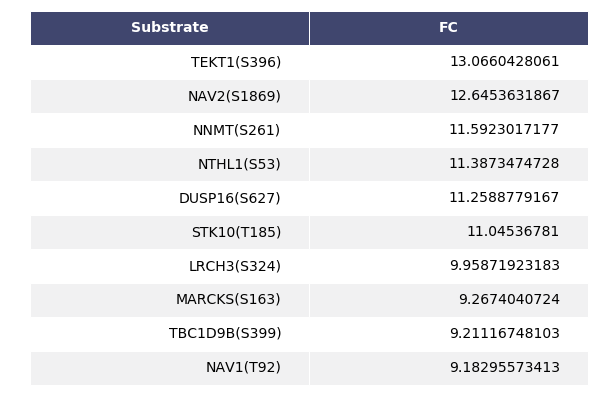

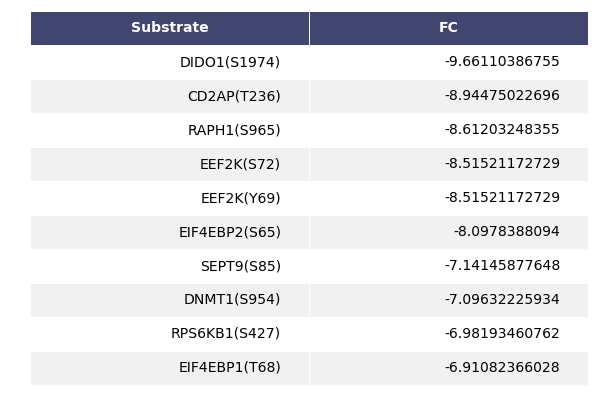

In [18]:
#code for extracting the top 10 up and down regulated substrates
log2tab=pd.DataFrame(data=df['log2']) # Taking the log2 fold change values
log2tab.columns = ['FC'] # renaming the columnn
log2table=pd.concat([df1,log2tab], axis=1, join_axes=[log2tab.index]) # table of the substrates and its fold changes

a10=log2table.nlargest(10,"FC" , keep='first') # The top 10 Upregulated substrates
b10=log2table.nsmallest(10,"FC", keep='first') # The top 10 Downregulated substrates
#print a10

#Creating an table function to create table and store the the top 10 up and down regulated substrates 
def render_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax
#Using the function 
render_table(a10, header_columns=0, col_width=5.0)
#plt.savefig('FCtop10.svg', transparent=True) #saving the table as an image
render_table(b10, header_columns=0, col_width=5.0)
#plt.savefig('FCbottom10.svg', transparent=True) #saving the table as an image

# Calculating Relative Activity (KScore)

Note: You have to have the file and the correct path

In [4]:
#Read our (editied) database using information Phosphosite plus
# You have to have the file and the correct path
dp=pd.read_csv("Phosphosites_basedOn_PSPlusdata_28Jan.csv",delimiter = ',' , index_col=0) 
#print dp

                              Key       Kinase Modification_Site  \
0      E2AK1_HUMAN(S52)eIF2-alpha  E2AK1_HUMAN               S52   
1      E2AK1_HUMAN(S49)eIF2-alpha  E2AK1_HUMAN               S49   
2           KPCD_HUMAN(S259)HDAC5   KPCD_HUMAN              S259   
3      KPCD_HUMAN(S204)PTPRA iso2   KPCD_HUMAN              S204   
4         KPCD_HUMAN(S302)hnRNP K   KPCD_HUMAN              S302   
5            KPCD_HUMAN(T71)SHOC2   KPCD_HUMAN               T71   
6             KPCD_HUMAN(S237)BVR   KPCD_HUMAN              S237   
7           KPCD_HUMAN(T1224)MUC1   KPCD_HUMAN             T1224   
8            KPCD_HUMAN(S726)ADD1   KPCD_HUMAN              S726   
9         KPCD_HUMAN(S370)p47phox   KPCD_HUMAN              S370   
10          KPCD_HUMAN(S504)ENOX2   KPCD_HUMAN              S504   
11          KPCD_HUMAN(T143)TNNI3   KPCD_HUMAN              T143   
12           KPCD_HUMAN(T217)FRA1   KPCD_HUMAN              T217   
13          KPCD_HUMAN(S358)BEST1   KPCD_HUMAN  

In [20]:
sig=df5[(df5['AZ20_p-value'] < 0.05)] #extracting significant phosphosites
sigp=pd.concat([sig,df1], axis=1, join_axes=[sig.index]) # substrate and p-values
dfp=sigp["Substrate"] #Getting substrate name for matching

In [21]:
match=list(dfp) # list of the phoshosites
match2d=pd.concat([dfp,fcut], axis=1, join_axes=[dfp.index])# made a table of the phosphosites and their fold change
match2d=match2d.replace([np.inf,-np.inf,np.nan]) # removing NaN values
matchds=match2d.rename(index=str, columns={"Substrate": "Search_key"}) # renamed the substrate to search key for the matching

In [22]:
#Performing the matching
phos = {}
listformatch = []
kinase = list(dp.Kinase) #list of kinases from our read database
match = list(dfp)  # list of significant (p-value) phosphosites
searchkey=list(dp.Search_key) # list of search key from our read database

# made a dictionary of the kinases and phosphosites match from the phosphosite plus database
for i in range(0, len(kinase)):
    if kinase[i] not in phos.keys():
        phos[kinase[i]] = [searchkey[i]]
    else:
        phos[kinase[i]].append(searchkey[i])

# print phos

# made a list of phoshosites from the phosphosite plus database to use for matching
for x in phos.values():
    x = list(x)
    listformatch.extend(x)
# print listformatch

# list of the matches
matchexist = []
for y in match:
    if y in listformatch:
        matchexist.append(y)

    else:
        pass
print matchexist

['ABCF1(S109)', 'ACACA(S80)', 'ADD2(S613)', 'AKIRIN2(S18)', 'AKT1S1(S183)', 'ANAPC1(S355)', 'ANAPC1(S377)', 'ARHGEF6(S225)', 'ARHGEF7(S518)', 'ATF2(T71)', 'BAD(S118)', 'BLVRA(S230)', 'BRCA1(S1189)', 'BRCA1(S1191)', 'BRCA1(S1497)', 'C1orf198(S37)', 'CAD(S1859)', 'CARHSP1(S52)', 'CBX5(S92)', 'CCDC6(S240)', 'CCT2(S260)', 'CD4(S440)', 'CD44(S706)', 'CDC20(S41)', 'CDC20(T157)', 'CDCA5(S83)', 'CDCA8(S219)', 'CDK12(T893)', 'CDK16(S153)', 'CELF1(S28)', 'CGN(S131)', 'CRMP1(S522)', 'CRMP1(T509)', 'CTNND1(S879)', 'CUEDC2(S110)', 'DDX24(S82)', 'DDX3Y(S592)', 'DLGAP5(S725)', 'DNMT1(S127)', 'DNMT1(S714)', 'DPYSL2(T509)', 'EDC3(S161)', 'EEF2K(S72)', 'EEF2K(S74)', 'EIF4A3(T163)', 'EIF4B(S406)', 'EIF4EBP1(S65)', 'EIF4EBP1(T46)', 'EIF4EBP1(T70)', 'EIF4G1(S1231)', 'ELAVL1(S202)', 'EPRS(S886)', 'EZH2(T367)', 'EZR(T567)', 'F11R(S284)', 'FAF1(S582)', 'GAPVD1(S950)', 'GBF1(T1337)', 'GINS2(S182)', 'GORASP2(T222)', 'GSK3B(Y216)', 'GTF2F1(S385)', 'GTF2F1(T389)', 'GTF2I(S784)', 'HNRNPA1(S199)', 'HNRNPU(S59)', 'H

In [23]:
#Getting rid of all column except search key and kinase
z=dp.drop(['Key', 'Substrate','Substrate_Gene','Substrate_Num','Uniprot_link','Modification_Site','Neighbour_Seq'], axis=1)

wsz=z[z["Search_key"].isin(matchexist)] # isin function to get the kinase which matched our list of matches


In [24]:
sff = pd.merge(wsz, matchds)  # Dataframe of the Kinase,Substrate and fold change

# made dict for kinase and the log 2 fold change
kinasedict = {}
kinases = list(sff["Kinase"])
foldch = list(sff['AZ20_fold_change'])
kinasecount = {}
# print kinaseff
count = 0
for i in range(0, len(sff)):
    if kinases[i] not in kinasedict.keys():
        kinasedict[kinases[i]] = [foldch[i]]

    else:
        kinasedict[kinases[i]].append(foldch[i])



# number of matches per kinase
for key, value in kinasedict.items():
    if key in kinasedict:
        # print len(value)
        kinasecount[key] = (len(value))
    else:
        pass

print kinasedict
#print kinasecount

{'KPCD_HUMAN': [-2.767835556728845, 1.1605820198040362, -2.6640066292721247], 'STK26_HUMAN': [-1.8705473492389508], 'MK14_HUMAN': [1.2319609309410757, -2.3905986189611195], 'UHMK1_HUMAN': [0.35174868849111096], 'MK03_HUMAN': [1.1605820198040362, -1.9977600629033834, 1.2319609309410757, 1.0599046065351994, 0.9678298914119913, -0.9096125607913198, 1.0085506851101669, 1.316614906906406, 0.35174868849111096, 0.672858501851916, -0.6920495059981514], 'KPCB_HUMAN': [0.35174868849111096], 'PDPK1_HUMAN': [0.5398893314922536], 'LMTK2_HUMAN': [0.5035530053056071], 'DYRK2_HUMAN': [-1.9977600629033834, 0.9113847193507547], 'M4K4_HUMAN': [-1.8705473492389508], 'NEK9_HUMAN': [-3.0372525499175156], 'MELK_HUMAN': [-0.31906894934820756], 'INSR_HUMAN': [-2.586157526818021], 'AKT1_HUMAN': [-2.9056010492809605, 0.49037202198038343, 0.5035530053056071, -0.11966015336377424, 1.0208824303746504, -3.41346599487291, -0.66323820808457, -1.8839331879359271, -0.6529381571339258, -1.0928084965137668], 'KPCG_HUMAN':

In [25]:
#Creating a dictionary of the kinase and their average log 2 fold change
avgDict = {}

for k,v in kinasedict.items():
    avgDict[k] = sum(v)/ float(len(v))


In [26]:
#Formula for calculating the kinase scores (Kscore)
log2r = np.log2(df4b) #log2 fold change for all of the substrates in our dataset
FCmean=np.ma.masked_invalid(log2r).sum()/len(log2r) #mean fold changes for all of the substrates in our dataset
sd=np.ma.masked_invalid(log2r).std()  #standard deviation of the log2 fold change across all of the substrates in the dataset

mvalues=list(kinasecount.values()) #list of total number of  substrates that matched to a specific kinase
mS=avgDict.values() # mean log2 fold change of known substrates of the given kinase 
m=[math.sqrt(x) for x in mvalues] #square root of the total number of  substrates that matched to a specific kinase

#Kinase scores (kscore) equation 
kscore=((mS-FCmean)*(m))/sd 
    
print kscore

[-2.1082007  -1.55664253 -0.81398202  0.13184923  0.50633958 -1.06633539
 -1.55664253  0.13184923 -1.48509905  0.67033557 -2.44310053 -2.10036031
 -2.52258029 -0.10201646  1.2705877  -2.11717028  0.61593183  0.80063102
 -0.85717268 -1.55664253  1.514063    0.5920831  -1.55664253 -3.0015472
 -0.29115507 -2.35563057  0.80063102  0.27281223  1.7759035   0.49277008
 -0.24149759  2.23349078  0.65268238 -0.54360469 -1.55664253 -0.85717268
  0.93215247 -2.10036031  0.250101   -0.21667873  1.24048681  2.05267711
 -0.22355585  0.23717469  0.13184923  0.80063102 -0.65024425 -1.6170796
  1.85974894 -1.03692975  2.4590959   0.93893876 -0.66122452  0.27479775
  1.79584875  0.171528   -5.52754478  1.34702905  0.71914516 -0.12897131
  2.1705549   1.28029765 -0.20909941 -0.78628828  0.24718955 -2.10036031
 -0.51982511 -0.49467451 -1.85713026  0.56890879 -2.20861661 -1.62847232
 -0.37783536 -0.22632535 -0.77515857  0.08464988 -2.10036031]


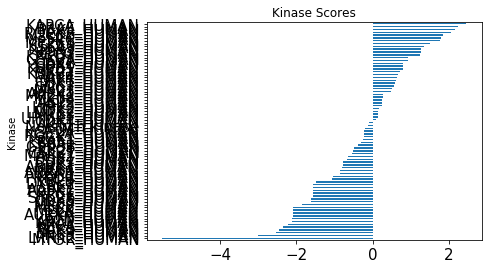

In [27]:
#Making a Dataframe of Kinase and Kscore
ksc = pd.DataFrame(data=kscore, columns=["Kscore"])
kinsc = list(kinasedict.keys())
ksms = pd.DataFrame(data=kinsc, columns=["Kinase"])
final = pd.concat([ksc, ksms], axis=1, join_axes=[ksms.index]) 

sortedf = final.sort_values(by="Kscore", axis=0)#Sorting the kscore values by value

#Plotting the graph of Kscores
sortedf.set_index('Kinase').plot.barh(title='Kinase Scores',legend=None)
plt.tick_params(labelsize = 15)
plt.rcParams['figure.figsize']=(35,35)
plt.show()

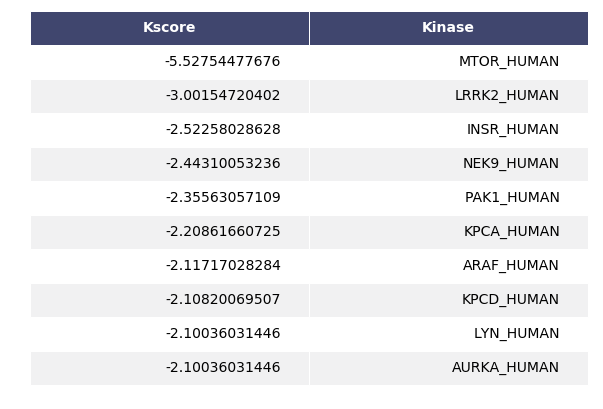

In [32]:
#Selecting top 10 up and down regulated kinases
top10=sortedf.nlargest(10, 'Kscore', keep='first')
bottom10=sortedf.nsmallest(10, 'Kscore', keep='first')

#Using render table function and saving it as an image
a=render_table(top10, header_columns=0, col_width=5.0)
#plt.savefig('KScoretop10.svg', transparent=True)
b=render_table(bottom10, header_columns=0, col_width=5.0)
#plt.savefig('KScorebottom10.svg', transparent=True)



In [65]:
#Kscores of all the dataset's Kinases saved to csv file 
kscore_file=sortedf.to_csv("Kscore_file", sep=',')
